# 02장_미로찾기를 위한 강화학습 구현

## 2.2 미로와 에이전트 구현

In [198]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
%matplotlib inline

### 미로구현

In [205]:
class Maze():
    def __init__(self):
        self.plot, self.line = self.make_maze()

    def make_maze(self):
        fig = plt.figure(figsize=(5,5))
        ax = plt.gca()
        wall_x=[[1,1],[1,2],[2,2],[2,3]]
        wall_y=[[0,1],[2,2],[2,1],[1,1]]
        for x, y in zip(wall_x, wall_y):
            plt.plot( x, y, color='red', linewidth=2)

        xplus, yplus=0, 0
        for i in range(9):
            xplus=i%3
            yplus=-1*(i//3)

            plt.text(0.5+xplus, 2.5+yplus, 'S%i'%i, size=14, ha='center')
        plt.text(0.5, 2.3, 'START', ha='center')
        plt.text(2.5, 0.3, 'GOAL', ha='center')

        ax.set_xlim(0,3)
        ax.set_ylim(0,3)
        plt.tick_params(axis='both', which='both', bottom=False, top=False,
                       labelbottom=False, right=False, left=False, labelleft=False)

        line, = ax.plot([0.5], [2.5], marker='o', color='lightblue', markersize=60)
        return fig, line

    def visualize(self, state_history):
        def init():
            self.line.set_data([],[])
            return (line, )
        
        def animate(i):
            state=state_history[i]
            x = (state %3)+0.5
            y = 2.5 -int(state/3)
            self.line.set_data(x,y)
            return (self.line,)

        anim = animation.FuncAnimation(self.plot, animate, init_func = init, 
                                      frames=len(state_history), interval=200, repeat=False)
        return anim.to_jshtml()

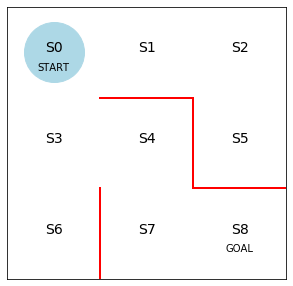

In [206]:
maze = Maze()

## policy $\pi_\theta (s, \alpha)$
* 상태가 $s$ 일때 행동 $\alpha$를 취할 확률은 파라미터 $\theta$가 결정하는 정책 $\pi$를 따른다

In [207]:
# 상, 우, 하, 좌
theta_0 = np.array([
    [np.nan, 1, 1, np.nan], #s0
    [np.nan, 1, np.nan, 1], #s1
    [np.nan, np.nan, 1, 1], #s2
    [1, 1, 1, np.nan], #s3
    [np.nan, np.nan, 1, 1], #s4
    [1, np.nan, np.nan, np.nan], #s5
    [1, np.nan, np.nan, np.nan], #s6
    [1, 1, np.nan, np.nan], #s7
    #s8은 목표지점이므로 정책이 없다.  
])

def simple_convert_into_pi_from_theta(theta):
    
    [m, n] = theta.shape
    pi = np.zeros((m,n))
    for i in range(0, m):
        pi[i,:] = theta[i,:]/np.nansum(theta[i,:])
    pi = np.nan_to_num(pi)
    return pi

def get_next_s(pi, s):
    direction=['up', 'right', 'down', 'left']
    next_direction= np.random.choice(direction, p=pi[s,:])
    if next_direction=='up': s_next=s-3
    elif next_direction=='right': s_next=s+1
    elif next_direction=='down': s_next=s+3
    elif next_direction=='left': s_next=s-1
    return s_next

def goal_maze(pi):
    s = 0
    state_history=[0]
    while True:
        next_s = get_next_s(pi, s)
        state_history.append(next_s)
        if next_s == 8:
            break
        else:
            s = next_s
    return state_history

In [208]:
pi_0 = simple_convert_into_pi_from_theta(theta_0)

In [209]:
state_history = goal_maze(pi_0)

In [211]:
anim = maze.visualize(state_history)
HTML(anim)

## 2.3 정책 반복 구현


### 정책 반복과 가치반복

 $P(\theta_i) = \frac{exp( \beta\theta_i )}{exp( \beta\theta_1 )+exp( \beta\theta_2 )+...}$ 
 = $\frac{exp( \beta\theta_i)}{\sum exp(\beta\theta_j)}$ 

### 정책경사 알고리즘에 따라 에이전트 이동시키기

In [35]:
def softmax_convert_into_pi_from_theta(theta):
    beta = 1.0
    [m, n] = theta.shape
    pi = np.zeros((m,n))
    
    exp_theta = np.exp(beta*theta)
    for i in range(0, m):
        pi[i,:]=theta[i, :]/np.nansum(theta[i,:])
        pi[i,:]=exp_theta[i,:]/np.nansum(exp_theta[i,:])
        
    pi = np.nan_to_num(pi)
    return pi

In [36]:
pi_0 = softmax_convert_into_pi_from_theta(theta_0)

In [132]:
'''

history     
================================================
   1        state1(input)    action1(output1) 
   2        state2(output2)     ...
   3
   .
   .
   
'''

def get_action_and_next_s(pi, s):
    direction=['up', 'right', 'down', 'left']
    next_direction= np.random.choice(direction, p=pi[s,:])
    
    if next_direction=='up': 
        action=0
        s_next=s-3 
    elif next_direction=='right': 
        action=1
        s_next=s+1
    elif next_direction=='down': 
        action=2
        s_next=s+3
    elif next_direction=='left': 
        action=3
        s_next=s-1
        
    return [action, s_next]

def goal_maze_ret_s_a(pi):
    s = 0
    #state, action
    state_history=[s]
    action_history = []
    
    while True:
        [action, next_s] = get_action_and_next_s(pi, s)

        state_history.append(next_s)
        action_history.append(action)
        
        if next_s == 8:
            action_history.append(np.nan)
            break
        else:
            s = next_s
    return state_history, action_history

In [212]:
state_history, action_history = goal_maze_ret_s_a(pi_0)
len(state_history), len(action_history)

(5, 5)

### 정책경사 알고리즘으로 정책 수정

In [156]:
def update_theta(theta, pi, state_history, action_history):
    eta = 0.1 #lr
    
    
    [m, n] = theta.shape
    delta_theta=theta.copy()
    
    s_a_history= np.array([state_history, action_history])
    s_a_history=s_a_history.transpose()
    T = len(s_a_history) # 목표지점까지 단계 수
        
    for i in range(0, m):
        for j in range(0,n):
            if not (np.isnan(theta[i,j])): 
                SA_i = [SA for SA in s_a_history if SA[0]==i]
                SA_ij = [SA for SA in s_a_history if (SA[0]==i and SA[1]==j)]

                N_i = len(SA_i) # 상태 i의 빈도
                N_ij = len(SA_ij) # 상태 i에서 행동 j를 취한 빈도
                
                delta_theta[i, j] = ( N_ij - pi[i,j]*N_i ) /T
    new_theta = theta + eta*delta_theta
    
    return new_theta

In [157]:
new_theta = update_theta(theta_0, pi_0, state_history, action_history)
new_theta

array([[  nan, 0.997, 1.003,   nan],
       [  nan, 1.002,   nan, 0.998],
       [  nan,   nan, 0.998, 1.002],
       [0.998, 0.998, 1.004,   nan],
       [  nan,   nan, 0.998, 1.002],
       [1.   ,   nan,   nan,   nan],
       [1.   ,   nan,   nan,   nan],
       [0.999, 1.001,   nan,   nan]])

In [158]:
pi = softmax_convert_into_pi_from_theta(new_theta)
pi

array([[0.   , 0.498, 0.502, 0.   ],
       [0.   , 0.501, 0.   , 0.499],
       [0.   , 0.   , 0.499, 0.501],
       [0.333, 0.333, 0.335, 0.   ],
       [0.   , 0.   , 0.499, 0.501],
       [1.   , 0.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   , 0.   ],
       [0.499, 0.501, 0.   , 0.   ]])

In [213]:
stop_epsilon = 10**-4
theta = theta_0
pi = pi_0

while True:
    state_history, action_history =goal_maze_ret_s_a(pi)
    new_theta=update_theta(theta, pi, state_history, action_history)
    new_pi = softmax_convert_into_pi_from_theta(new_theta)
    
    epsilon = np.sum(np.abs(new_pi-pi))
    print(epsilon)
    print("목표지점까지 걸린 단계 수는 %i 입니다"%(len(action_history)-1))
    
    if epsilon < stop_epsilon: break
    else: 
        theta = new_theta
        pi = new_pi

0.005824787345110438
목표지점까지 걸린 단계 수는 40 입니다
0.005117626812637055
목표지점까지 걸린 단계 수는 80 입니다
0.010909600348575632
목표지점까지 걸린 단계 수는 76 입니다
0.02108579055345211
목표지점까지 걸린 단계 수는 8 입니다
0.004470126396725171
목표지점까지 걸린 단계 수는 54 입니다
0.015675106535264716
목표지점까지 걸린 단계 수는 42 입니다
0.012675699107584482
목표지점까지 걸린 단계 수는 60 입니다
0.026743541170105745
목표지점까지 걸린 단계 수는 10 입니다
0.006733091535731761
목표지점까지 걸린 단계 수는 88 입니다
0.01359962040974566
목표지점까지 걸린 단계 수는 106 입니다
0.011462647135858539
목표지점까지 걸린 단계 수는 38 입니다
0.025138120236241512
목표지점까지 걸린 단계 수는 16 입니다
0.01430928303569079
목표지점까지 걸린 단계 수는 40 입니다
0.038928470688033845
목표지점까지 걸린 단계 수는 4 입니다
0.011780606822002548
목표지점까지 걸린 단계 수는 28 입니다
0.0072203781650972965
목표지점까지 걸린 단계 수는 70 입니다
0.0053894690028795655
목표지점까지 걸린 단계 수는 228 입니다
0.010937028144655914
목표지점까지 걸린 단계 수는 28 입니다
0.012543589603999594
목표지점까지 걸린 단계 수는 26 입니다
0.016690359101403762
목표지점까지 걸린 단계 수는 18 입니다
0.01406527469265162
목표지점까지 걸린 단계 수는 82 입니다
0.023886072267685965
목표지점까지 걸린 단계 수는 8 입니다
0.010042108589945642
목표지점까지 걸린 단계 수

0.019684503834867362
목표지점까지 걸린 단계 수는 6 입니다
0.016301179392191195
목표지점까지 걸린 단계 수는 14 입니다
0.024297908748562302
목표지점까지 걸린 단계 수는 4 입니다
0.014088993981841574
목표지점까지 걸린 단계 수는 18 입니다
0.02043530490219797
목표지점까지 걸린 단계 수는 26 입니다
0.015469759262938587
목표지점까지 걸린 단계 수는 10 입니다
0.019401651201759434
목표지점까지 걸린 단계 수는 6 입니다
0.020307259014154866
목표지점까지 걸린 단계 수는 10 입니다
0.011972408399221757
목표지점까지 걸린 단계 수는 16 입니다
0.019211975995393704
목표지점까지 걸린 단계 수는 6 입니다
0.02394904072145307
목표지점까지 걸린 단계 수는 8 입니다
0.02341778743870157
목표지점까지 걸린 단계 수는 10 입니다
0.02855550906827492
목표지점까지 걸린 단계 수는 8 입니다
0.015246300154541786
목표지점까지 걸린 단계 수는 10 입니다
0.01864729487308195
목표지점까지 걸린 단계 수는 10 입니다
0.023897406591370823
목표지점까지 걸린 단계 수는 4 입니다
0.020478680829064344
목표지점까지 걸린 단계 수는 12 입니다
0.012796270675399818
목표지점까지 걸린 단계 수는 24 입니다
0.023797241220524235
목표지점까지 걸린 단계 수는 4 입니다
0.023730511381876374
목표지점까지 걸린 단계 수는 14 입니다
0.015870665165459735
목표지점까지 걸린 단계 수는 6 입니다
0.01940912162425351
목표지점까지 걸린 단계 수는 20 입니다
0.018112588256809364
목표지점까지 걸린 단계 수는 10 입니다
0.0

0.013853595311651229
목표지점까지 걸린 단계 수는 6 입니다
0.013748918039881403
목표지점까지 걸린 단계 수는 6 입니다
0.01592617054531212
목표지점까지 걸린 단계 수는 10 입니다
0.013601953616099866
목표지점까지 걸린 단계 수는 4 입니다
0.013451181703359905
목표지점까지 걸린 단계 수는 4 입니다
0.013302383907340898
목표지점까지 걸린 단계 수는 4 입니다
0.013155537805196293
목표지점까지 걸린 단계 수는 4 입니다
0.015156487351829367
목표지점까지 걸린 단계 수는 20 입니다
0.012748733545656449
목표지점까지 걸린 단계 수는 8 입니다
0.01784285416152212
목표지점까지 걸린 단계 수는 6 입니다
0.01590134007869276
목표지점까지 걸린 단계 수는 10 입니다
0.013152446449944732
목표지점까지 걸린 단계 수는 4 입니다
0.01000024070936456
목표지점까지 걸린 단계 수는 6 입니다
0.012978878811308492
목표지점까지 걸린 단계 수는 4 입니다
0.01426019978341958
목표지점까지 걸린 단계 수는 12 입니다
0.013015970539026034
목표지점까지 걸린 단계 수는 8 입니다
0.012926585044886224
목표지점까지 걸린 단계 수는 4 입니다
0.00980155320263551
목표지점까지 걸린 단계 수는 6 입니다
0.009721327881088898
목표지점까지 걸린 단계 수는 12 입니다
0.015878734266086186
목표지점까지 걸린 단계 수는 10 입니다
0.01285271849165176
목표지점까지 걸린 단계 수는 4 입니다
0.012712268397406773
목표지점까지 걸린 단계 수는 4 입니다
0.009734839771154108
목표지점까지 걸린 단계 수는 6 입니다
0.0151506747

0.006724847069875278
목표지점까지 걸린 단계 수는 4 입니다
0.0066639237243520805
목표지점까지 걸린 단계 수는 4 입니다
0.006603740559423407
목표지점까지 걸린 단계 수는 4 입니다
0.007218618524984136
목표지점까지 걸린 단계 수는 6 입니다
0.0101276160808655
목표지점까지 걸린 단계 수는 12 입니다
0.006640191605989776
목표지점까지 걸린 단계 수는 4 입니다
0.00658029070682363
목표지점까지 걸린 단계 수는 4 입니다
0.006521114361581953
목표지점까지 걸린 단계 수는 4 입니다
0.006462652371238095
목표지점까지 걸린 단계 수는 4 입니다
0.006404894682377246
목표지점까지 걸린 단계 수는 4 입니다
0.00634783138569997
목표지점까지 걸린 단계 수는 4 입니다
0.015753438673268727
목표지점까지 걸린 단계 수는 10 입니다
0.009348484624145031
목표지점까지 걸린 단계 수는 6 입니다
0.010500078317209643
목표지점까지 걸린 단계 수는 8 입니다
0.006357544526368761
목표지점까지 걸린 단계 수는 4 입니다
0.006300966112111381
목표지점까지 걸린 단계 수는 4 입니다
0.0062450689982901375
목표지점까지 걸린 단계 수는 4 입니다
0.010107416886415296
목표지점까지 걸린 단계 수는 6 입니다
0.006180254607930508
목표지점까지 걸린 단계 수는 4 입니다
0.0061258208367219735
목표지점까지 걸린 단계 수는 4 입니다
0.009180963912175807
목표지점까지 걸린 단계 수는 6 입니다
0.0060870939582543665
목표지점까지 걸린 단계 수는 4 입니다
0.012374087055097654
목표지점까지 걸린 단계 수는 10 입니다
0.009186

0.0031389510326997327
목표지점까지 걸린 단계 수는 4 입니다
0.003117618049743087
목표지점까지 걸린 단계 수는 4 입니다
0.010031284816045996
목표지점까지 걸린 단계 수는 6 입니다
0.003105724372650498
목표지점까지 걸린 단계 수는 4 입니다
0.00538753589827172
목표지점까지 걸린 단계 수는 6 입니다
0.0030986666753113346
목표지점까지 걸린 단계 수는 4 입니다
0.0030777458870380886
목표지점까지 걸린 단계 수는 4 입니다
0.006312357642645525
목표지점까지 걸린 단계 수는 6 입니다
0.0030768042932128176
목표지점까지 걸린 단계 수는 4 입니다
0.003056060455425294
목표지점까지 걸린 단계 수는 4 입니다
0.008040638271424982
목표지점까지 걸린 단계 수는 8 입니다
0.003079298091128932
목표지점까지 걸린 단계 수는 4 입니다
0.0030585115298014526
목표지점까지 걸린 단계 수는 4 입니다
0.009085444326179443
목표지점까지 걸린 단계 수는 8 입니다
0.003081164448668447
목표지점까지 걸린 단계 수는 4 입니다
0.005433009571117142
목표지점까지 걸린 단계 수는 6 입니다
0.003081277532991006
목표지점까지 걸린 단계 수는 4 입니다
0.003060404858791846
목표지점까지 걸린 단계 수는 4 입니다
0.003039734175792966
목표지점까지 걸린 단계 수는 4 입니다
0.00301926300373577
목표지점까지 걸린 단계 수는 4 입니다
0.0029989888983570773
목표지점까지 걸린 단계 수는 4 입니다
0.005262508214524439
목표지점까지 걸린 단계 수는 6 입니다
0.005281923257887844
목표지점까지 걸린 단계 수는 6 입니다
0.00538

0.0018728019481005428
목표지점까지 걸린 단계 수는 4 입니다
0.0046117043105016325
목표지점까지 걸린 단계 수는 6 입니다
0.001865315194530863
목표지점까지 걸린 단계 수는 4 입니다
0.005980287594511691
목표지점까지 걸린 단계 수는 8 입니다
0.006033421954440593
목표지점까지 걸린 단계 수는 8 입니다
0.004724874443893648
목표지점까지 걸린 단계 수는 6 입니다
0.0018994810616057775
목표지점까지 걸린 단계 수는 4 입니다
0.001888993830672446
목표지점까지 걸린 단계 수는 4 입니다
0.001878590872193206
목표지점까지 걸린 단계 수는 4 입니다
0.0018682713103536502
목표지점까지 걸린 단계 수는 4 입니다
0.0018580342803368524
목표지점까지 걸린 단계 수는 4 입니다
0.006170827541317585
목표지점까지 걸린 단계 수는 8 입니다
0.0018795015576437077
목표지점까지 걸린 단계 수는 4 입니다
0.0018691536025831415
목표지점까지 걸린 단계 수는 4 입니다
0.004247363489801904
목표지점까지 걸린 단계 수는 6 입니다
0.004710575678322962
목표지점까지 걸린 단계 수는 6 입니다
0.00187781409202753
목표지점까지 걸린 단계 수는 4 입니다
0.0018674896339193198
목표지점까지 걸린 단계 수는 4 입니다
0.0018572478331427
목표지점까지 걸린 단계 수는 4 입니다
0.001847087833657779
목표지점까지 걸린 단계 수는 4 입니다
0.0018370087901368251
목표지점까지 걸린 단계 수는 4 입니다
0.005990157042756274
목표지점까지 걸린 단계 수는 10 입니다
0.0018542159886328277
목표지점까지 걸린 단계 수는 4 입니다
0.0

0.0014446256012440664
목표지점까지 걸린 단계 수는 4 입니다
0.0014375887216439218
목표지점까지 걸린 단계 수는 4 입니다
0.0014306020661320126
목표지점까지 걸린 단계 수는 4 입니다
0.0014236651676626522
목표지점까지 걸린 단계 수는 4 입니다
0.0014167775644839467
목표지점까지 걸린 단계 수는 4 입니다
0.0038474522500367217
목표지점까지 걸린 단계 수는 6 입니다
0.0014229947565629827
목표지점까지 걸린 단계 수는 4 입니다
0.003873438570294742
목표지점까지 걸린 단계 수는 6 입니다
0.0014295446229383307
목표지점까지 걸린 단계 수는 4 입니다
0.0014225946429950176
목표지점까지 걸린 단계 수는 4 입니다
0.0014156942247090035
목표지점까지 걸린 단계 수는 4 입니다
0.0014088429074421288
목표지점까지 걸린 단계 수는 4 입니다
0.0014020402357732137
목표지점까지 걸린 단계 수는 4 입니다
0.001395285759428412
목표지점까지 걸린 단계 수는 4 입니다
0.017392933771496012
목표지점까지 걸린 단계 수는 12 입니다
0.008130323456979796
목표지점까지 걸린 단계 수는 8 입니다
0.0014124527071042031
목표지점까지 걸린 단계 수는 4 입니다
0.001405651789469095
목표지점까지 걸린 단계 수는 4 입니다
0.007585038916894618
목표지점까지 걸린 단계 수는 6 입니다
0.0014056819461796752
목표지점까지 걸린 단계 수는 4 입니다
0.0013989410289502319
목표지점까지 걸린 단계 수는 4 입니다
0.0013922474452797082
목표지점까지 걸린 단계 수는 4 입니다
0.001385600762213432
목표지점까지 걸린 단계 수는 

0.0009448300952625693
목표지점까지 걸린 단계 수는 4 입니다
0.0009410059621944439
목표지점까지 걸린 단계 수는 4 입니다
0.0009372048073750458
목표지점까지 걸린 단계 수는 4 입니다
0.000933426448740074
목표지점까지 걸린 단계 수는 4 입니다
0.000929670706005109
목표지점까지 걸린 단계 수는 4 입니다
0.0030675497511238256
목표지점까지 걸린 단계 수는 6 입니다
0.0009296887630525844
목표지점까지 걸린 단계 수는 4 입니다
0.0009259643243184693
목표지점까지 걸린 단계 수는 4 입니다
0.0009222620175329752
목표지점까지 걸린 단계 수는 4 입니다
0.0009185816693418405
목표지점까지 걸린 단계 수는 4 입니다
0.0009149231080649647
목표지점까지 걸린 단계 수는 4 입니다
0.0009112861636783529
목표지점까지 걸린 단계 수는 4 입니다
0.0009076706677947494
목표지점까지 걸린 단계 수는 4 입니다
0.0009040764536452223
목표지점까지 걸린 단계 수는 4 입니다
0.0009005033560607889
목표지점까지 걸린 단계 수는 4 입니다
0.0008969512114542499
목표지점까지 걸린 단계 수는 4 입니다
0.0008934198578020788
목표지점까지 걸린 단계 수는 4 입니다
0.0008899091346267277
목표지점까지 걸린 단계 수는 4 입니다
0.0008864188829805358
목표지점까지 걸린 단계 수는 4 입니다
0.0008829489454260722
목표지점까지 걸린 단계 수는 4 입니다
0.0008794991660204532
목표지점까지 걸린 단계 수는 4 입니다
0.0008760693902997232
목표지점까지 걸린 단계 수는 4 입니다
0.0008726594652606057
목표지점까지 걸린 단계

0.0008116497144463053
목표지점까지 걸린 단계 수는 4 입니다
0.0008085399174383931
목표지점까지 걸린 단계 수는 4 입니다
0.0008054479600685463
목표지점까지 걸린 단계 수는 4 입니다
0.0008023737065710884
목표지점까지 걸린 단계 수는 4 입니다
0.0007993170224634416
목표지점까지 걸린 단계 수는 4 입니다
0.0007962777745262467
목표지점까지 걸린 단계 수는 4 입니다
0.000793255830794086
목표지점까지 걸린 단계 수는 4 입니다
0.0007902510605380039
목표지점까지 걸린 단계 수는 4 입니다
0.006224291031339618
목표지점까지 걸린 단계 수는 6 입니다
0.0007908960226001016
목표지점까지 걸린 단계 수는 4 입니다
0.003087289602421009
목표지점까지 걸린 단계 수는 6 입니다
0.0007964636142456308
목표지점까지 걸린 단계 수는 4 입니다
0.0007934470047838982
목표지점까지 걸린 단계 수는 4 입니다
0.0007904474886156129
목표지점까지 걸린 단계 수는 4 입니다
0.0031192541453917352
목표지점까지 걸린 단계 수는 6 입니다
0.0007963762593022616
목표지점까지 걸린 단계 수는 4 입니다
0.0007933571376576576
목표지점까지 걸린 단계 수는 4 입니다
0.000790355144067785
목표지점까지 걸린 단계 수는 4 입니다
0.0007873701496438623
목표지점까지 걸린 단계 수는 4 입니다
0.0007844020266988133
목표지점까지 걸린 단계 수는 4 입니다
0.0007814506487349229
목표지점까지 걸린 단계 수는 4 입니다
0.006195356547069639
목표지점까지 걸린 단계 수는 6 입니다
0.0007822790031390345
목표지점까지 걸린 단계 수는

0.0005670924679899193
목표지점까지 걸린 단계 수는 4 입니다
0.0005652282814184346
목표지점까지 걸린 단계 수는 4 입니다
0.0005633733747277686
목표지점까지 걸린 단계 수는 4 입니다
0.0005615276860894171
목표지점까지 걸린 단계 수는 4 입니다
0.0005596911541894886
목표지점까지 걸린 단계 수는 4 입니다
0.0005578637182228549
목표지점까지 걸린 단계 수는 4 입니다
0.0005560453178898063
목표지점까지 걸린 단계 수는 4 입니다
0.000554235893387444
목표지점까지 걸린 단계 수는 4 입니다
0.0005524353854095589
목표지점까지 걸린 단계 수는 4 입니다
0.000550643735136129
목표지점까지 걸린 단계 수는 4 입니다
0.0005488608842346664
목표지점까지 걸린 단계 수는 4 입니다
0.0005470867748500301
목표지점까지 걸린 단계 수는 4 입니다
0.0005453213496033095
목표지점까지 걸린 단계 수는 4 입니다
0.0034035896867671764
목표지점까지 걸린 단계 수는 10 입니다
0.0005527153347167531
목표지점까지 걸린 단계 수는 4 입니다
0.016175789035926147
목표지점까지 걸린 단계 수는 28 입니다
0.002487143021775655
목표지점까지 걸린 단계 수는 6 입니다
0.0005590449974051115
목표지점까지 걸린 단계 수는 4 입니다
0.0027610025467225546
목표지점까지 걸린 단계 수는 6 입니다
0.0005665745992544553
목표지점까지 걸린 단계 수는 4 입니다
0.0005647066147178026
목표지점까지 걸린 단계 수는 4 입니다
0.0005628479783252524
목표지점까지 걸린 단계 수는 4 입니다
0.000560998627343455
목표지점까지 걸린 단계 

0.00043804933649128214
목표지점까지 걸린 단계 수는 4 입니다
0.0004367630577199154
목표지점까지 걸린 단계 수는 4 입니다
0.00043548254778091877
목표지점까지 걸린 단계 수는 4 입니다
0.00043420777179816253
목표지점까지 걸린 단계 수는 4 입니다
0.00043293869515910466
목표지점까지 걸린 단계 수는 4 입니다
0.0004316752835149193
목표지점까지 걸린 단계 수는 4 입니다
0.0004304175027762362
목표지점까지 걸린 단계 수는 4 입니다
0.00042916531911098635
목표지점까지 걸린 단계 수는 4 입니다
0.0004279186989432776
목표지점까지 걸린 단계 수는 4 입니다
0.00042667760894909285
목표지점까지 걸린 단계 수는 4 입니다
0.002629712220090147
목표지점까지 걸린 단계 수는 8 입니다
0.00043202206378905456
목표지점까지 걸린 단계 수는 4 입니다
0.0004307632621544724
목표지점까지 걸린 단계 수는 4 입니다
0.002483538907457332
목표지점까지 걸린 단계 수는 6 입니다
0.005643237110112748
목표지점까지 걸린 단계 수는 8 입니다
0.0004451148761928682
목표지점까지 걸린 단계 수는 4 입니다
0.00044379179575664007
목표지점까지 걸린 단계 수는 4 입니다
0.0004424747368862239
목표지점까지 걸린 단계 수는 4 입니다
0.000441163662575135
목표지점까지 걸린 단계 수는 4 입니다
0.0004398585361040791
목표지점까지 걸린 단계 수는 4 입니다
0.00043855932103461365
목표지점까지 걸린 단계 수는 4 입니다
0.00043726598121128155
목표지점까지 걸린 단계 수는 4 입니다
0.0021260565692844784
목표지점

0.0003997353600205186
목표지점까지 걸린 단계 수는 4 입니다
0.0003985915113463162
목표지점까지 걸린 단계 수는 4 입니다
0.0003974527084465891
목표지점까지 걸린 단계 수는 4 입니다
0.00039631892113368636
목표지점까지 걸린 단계 수는 4 입니다
0.0003951901194492839
목표지점까지 걸린 단계 수는 4 입니다
0.00039406627365977734
목표지점까지 걸린 단계 수는 4 입니다
0.00039294735425588617
목표지점까지 걸린 단계 수는 4 입니다
0.00039183333194880293
목표지점까지 걸린 단계 수는 4 입니다
0.0003907241776695339
목표지점까지 걸린 단계 수는 4 입니다
0.00038961986256674797
목표지점까지 걸린 단계 수는 4 입니다
0.00038852035800432394
목표지점까지 걸린 단계 수는 4 입니다
0.00038742563555995563
목표지점까지 걸린 단계 수는 4 입니다
0.0003863356670223729
목표지점까지 걸린 단계 수는 4 입니다
0.0003852504243913417
목표지점까지 걸린 단계 수는 4 입니다
0.0019593778719245204
목표지점까지 걸린 단계 수는 6 입니다
0.000387826598459564
목표지점까지 걸린 단계 수는 4 입니다
0.0003867374562179539
목표지점까지 걸린 단계 수는 4 입니다
0.0003856530196331004
목표지점까지 걸린 단계 수는 4 입니다
0.0003845732611653767
목표지점까지 걸린 단계 수는 4 입니다
0.00038349815348031474
목표지점까지 걸린 단계 수는 4 입니다
0.0003824276694434983
목표지점까지 걸린 단계 수는 4 입니다
0.0003813617821209134
목표지점까지 걸린 단계 수는 4 입니다
0.00038030046477438226
목표

0.00032883448867932624
목표지점까지 걸린 단계 수는 4 입니다
0.001852823643516778
목표지점까지 걸린 단계 수는 6 입니다
0.00033139938014557085
목표지점까지 걸린 단계 수는 4 입니다
0.0016095745519690216
목표지점까지 걸린 단계 수는 6 입니다
0.0003319983415522483
목표지점까지 걸린 단계 수는 4 입니다
0.0003311402739235199
목표지점까지 걸린 단계 수는 4 입니다
0.0003302856096430336
목표지점까지 걸린 단계 수는 4 입니다
0.00032943433044535855
목표지점까지 걸린 단계 수는 4 입니다
0.0003285864181908002
목표지점까지 걸린 단계 수는 4 입니다
0.00032774185485951596
목표지점까지 걸린 단계 수는 4 입니다
0.0003269006225559909
목표지점까지 걸린 단계 수는 4 입니다
0.0003260627035026921
목표지점까지 걸린 단계 수는 4 입니다
0.00032522808004228215
목표지점까지 걸린 단계 수는 4 입니다
0.0003243967346379141
목표지점까지 걸린 단계 수는 4 입니다
0.0003235686498672223
목표지점까지 걸린 단계 수는 4 입니다
0.0003227438084262464
목표지점까지 걸린 단계 수는 4 입니다
0.00032192219312683623
목표지점까지 걸린 단계 수는 4 입니다
0.0016136295264487718
목표지점까지 걸린 단계 수는 6 입니다
0.00032268074637686536
목표지점까지 걸린 단계 수는 4 입니다
0.00032186230640442876
목표지점까지 걸린 단계 수는 4 입니다
0.0024813399269458837
목표지점까지 걸린 단계 수는 8 입니다
0.00032549106842306996
목표지점까지 걸린 단계 수는 4 입니다
0.0003246648627698717
목표

0.0002857174607109429
목표지점까지 걸린 단계 수는 4 입니다
0.00028502974922779006
목표지점까지 걸린 단계 수는 4 입니다
0.0002843445819066953
목표지점까지 걸린 단계 수는 4 입니다
0.000283661945997396
목표지점까지 걸린 단계 수는 4 입니다
0.00028298182883161604
목표지점까지 걸린 단계 수는 4 입니다
0.002056753897933611
목표지점까지 걸린 단계 수는 6 입니다
0.0002877350102009242
목표지점까지 걸린 단계 수는 4 입니다
0.0002870368290096535
목표지점까지 걸린 단계 수는 4 입니다
0.00028634125684980777
목표지점까지 걸린 단계 수는 4 입니다
0.0002856482804982352
목표지점까지 걸린 단계 수는 4 입니다
0.00028495788681597717
목표지점까지 걸린 단계 수는 4 입니다
0.00028427006274875724
목표지점까지 걸린 단계 수는 4 입니다
0.00028358479532338346
목표지점까지 걸린 단계 수는 4 입니다
0.0014065194077084037
목표지점까지 걸린 단계 수는 6 입니다
0.00028398486905948164
목표지점까지 걸린 단계 수는 4 입니다
0.0002833032006474348
목표지점까지 걸린 단계 수는 4 입니다
0.0002826240491282765
목표지점까지 걸린 단계 수는 4 입니다
0.00028194740190241527
목표지점까지 걸린 단계 수는 4 입니다
0.0002812732464491652
목표지점까지 걸린 단계 수는 4 입니다
0.00028060157032756133
목표지점까지 걸린 단계 수는 4 입니다
0.0002799323611748679
목표지점까지 걸린 단계 수는 4 입니다
0.000279265606704885
목표지점까지 걸린 단계 수는 4 입니다
0.00027860129471094647
목표지

0.0002221782801176582
목표지점까지 걸린 단계 수는 4 입니다
0.0002217211058055113
목표지점까지 걸린 단계 수는 4 입니다
0.00022126535956839763
목표지점까지 걸린 단계 수는 4 입니다
0.0002208110354026925
목표지점까지 걸린 단계 수는 4 입니다
0.0002203581273370822
목표지점까지 걸린 단계 수는 4 입니다
0.0012903342790365722
목표지점까지 걸린 단계 수는 6 입니다
0.00022116477253529554
목표지점까지 걸린 단계 수는 4 입니다
0.0002207121665883105
목표지점까지 걸린 단계 수는 4 입니다
0.00022026096491673322
목표지점까지 걸린 단계 수는 4 입니다
0.0002198111616625413
목표지점까지 걸린 단계 수는 4 입니다
0.0002193627509974004
목표지점까지 걸린 단계 수는 4 입니다
0.0016021705057992844
목표지점까지 걸린 단계 수는 6 입니다
0.00022177959412549367
목표지점까지 걸린 단계 수는 4 입니다
0.00022132481468732992
목표지점까지 걸린 단계 수는 4 입니다
0.00022087144896217048
목표지점까지 걸린 단계 수는 4 입니다
0.00022041949104353517
목표지점까지 걸린 단계 수는 4 입니다
0.00021996893505441678
목표지점까지 걸린 단계 수는 4 입니다
0.0002195197751500011
목표지점까지 걸린 단계 수는 4 입니다
0.0002190720055153944
목표지점까지 걸린 단계 수는 4 입니다
0.00021862562036670252
목표지점까지 걸린 단계 수는 4 입니다
0.00021818061394976093
목표지점까지 걸린 단계 수는 4 입니다
0.0002177369805402285
목표지점까지 걸린 단계 수는 4 입니다
0.00021729471444504114

0.0012181140942390412
목표지점까지 걸린 단계 수는 6 입니다
0.00019193182754214527
목표지점까지 걸린 단계 수는 4 입니다
0.00019156893316322164
목표지점까지 걸린 단계 수는 4 입니다
0.00019120707570926578
목표지점까지 걸린 단계 수는 4 입니다
0.00019084625120003966
목표지점까지 걸린 단계 수는 4 입니다
0.00019048645567766934
목표지점까지 걸린 단계 수는 4 입니다
0.00019012768520246769
목표지점까지 걸린 단계 수는 4 입니다
0.00018976993585257187
목표지점까지 걸린 단계 수는 4 입니다
0.00018941320372671024
목표지점까지 걸린 단계 수는 4 입니다
0.00018905748493976138
목표지점까지 걸린 단계 수는 4 입니다
0.00018870277562945542
목표지점까지 걸린 단계 수는 4 입니다
0.00018834907194762926
목표지점까지 걸린 단계 수는 4 입니다
0.00018799637006746382
목표지점까지 걸린 단계 수는 4 입니다
0.00018764466617946646
목표지점까지 걸린 단계 수는 4 입니다
0.0001872939564921336
목표지점까지 걸린 단계 수는 4 입니다
0.00018694423723156738
목표지점까지 걸린 단계 수는 4 입니다
0.0001865955046440361
목표지점까지 걸린 단계 수는 4 입니다
0.00018624775499138414
목표지점까지 걸린 단계 수는 4 입니다
0.00018590098455442856
목표지점까지 걸린 단계 수는 4 입니다
0.0012245168302391328
목표지점까지 걸린 단계 수는 6 입니다
0.000186831698790961
목표지점까지 걸린 단계 수는 4 입니다
0.0001864842158097995
목표지점까지 걸린 단계 수는 4 입니다
0.000186137708045

0.0001705035417419072
목표지점까지 걸린 단계 수는 4 입니다
0.0001702011636665699
목표지점까지 걸린 단계 수는 4 입니다
0.00016989959397732159
목표지점까지 걸린 단계 수는 4 입니다
0.000169598829776978
목표지점까지 걸린 단계 수는 4 입니다
0.00016929886818169149
목표지점까지 걸린 단계 수는 4 입니다
0.00016899970632052244
목표지점까지 걸린 단계 수는 4 입니다
0.0001687013413350768
목표지점까지 걸린 단계 수는 4 입니다
0.00016840377037976272
목표지점까지 걸린 단계 수는 4 입니다
0.00016810699062304313
목표지점까지 걸린 단계 수는 4 입니다
0.00016781099924390898
목표지점까지 걸린 단계 수는 4 입니다
0.0001675157934354632
목표지점까지 걸린 단계 수는 4 입니다
0.00016722137040352247
목표지점까지 걸린 단계 수는 4 입니다
0.0014937240763297412
목표지점까지 걸린 단계 수는 6 입니다
0.00016971682567139962
목표지점까지 걸린 단계 수는 4 입니다
0.00016941552732191965
목표지점까지 걸린 단계 수는 4 입니다
0.00016911503695244377
목표지점까지 걸린 단계 수는 4 입니다
0.00016881535165392397
목표지점까지 걸린 단계 수는 4 입니다
0.00016851646852855673
목표지점까지 걸린 단계 수는 4 입니다
0.00016821838469397755
목표지점까지 걸린 단계 수는 4 입니다
0.0001679210972799338
목표지점까지 걸린 단계 수는 4 입니다
0.0001676246034267876
목표지점까지 걸린 단계 수는 4 입니다
0.00016732890029242525
목표지점까지 걸린 단계 수는 4 입니다
0.00016703398504390

0.00013620223140891653
목표지점까지 걸린 단계 수는 4 입니다
0.0001359882166166778
목표지점까지 걸린 단계 수는 4 입니다
0.00013577470610270752
목표지점까지 걸린 단계 수는 4 입니다
0.0001355616982821068
목표지점까지 걸린 단계 수는 4 입니다
0.00013534919157417828
목표지점까지 걸린 단계 수는 4 입니다
0.00013513718440661023
목표지점까지 걸린 단계 수는 4 입니다
0.0001349256752120765
목표지점까지 걸린 단계 수는 4 입니다
0.00013471466242934507
목표지점까지 걸린 단계 수는 4 입니다
0.00013450414450392155
목표지점까지 걸린 단계 수는 4 입니다
0.0001342941198867395
목표지점까지 걸린 단계 수는 4 입니다
0.0001340845870354112
목표지점까지 걸린 단계 수는 4 입니다
0.00013387554441321448
목표지점까지 걸린 단계 수는 4 입니다
0.00013366699048937732
목표지점까지 걸린 단계 수는 4 입니다
0.00013345892373910033
목표지점까지 걸린 단계 수는 4 입니다
0.00013325134264500528
목표지점까지 걸린 단계 수는 4 입니다
0.0001330442456924149
목표지점까지 걸린 단계 수는 4 입니다
0.00013283763137554583
목표지점까지 걸린 단계 수는 4 입니다
0.00013263149819353094
목표지점까지 걸린 단계 수는 4 입니다
0.00013242584465097094
목표지점까지 걸린 단계 수는 4 입니다
0.00013222066925821195
목표지점까지 걸린 단계 수는 4 입니다
0.0001320159705320914
목표지점까지 걸린 단계 수는 4 입니다
0.0001318117469948539
목표지점까지 걸린 단계 수는 4 입니다
0.0001316079971744

0.0001208480385476874
목표지점까지 걸린 단계 수는 4 입니다
0.0011646774836164518
목표지점까지 걸린 단계 수는 6 입니다
0.00012225100109540185
목표지점까지 걸린 단계 수는 4 입니다
0.00012206821802590063
목표지점까지 걸린 단계 수는 4 입니다
0.00012188584542594492
목표지점까지 걸린 단계 수는 4 입니다
0.00012170388206399381
목표지점까지 걸린 단계 수는 4 입니다
0.00012152232671262635
목표지점까지 걸린 단계 수는 4 입니다
0.00012134117815038731
목표지점까지 걸린 단계 수는 4 입니다
0.00012116043515974367
목표지점까지 걸린 단계 수는 4 입니다
0.00012098009652758944
목표지점까지 걸린 단계 수는 4 입니다
0.00012080016104526643
목표지점까지 걸린 단계 수는 4 입니다
0.00012062062750900146
목표지점까지 걸린 단계 수는 4 입니다
0.00012044149471941712
목표지점까지 걸린 단계 수는 4 입니다
0.0001202627614812074
목표지점까지 걸린 단계 수는 4 입니다
0.0001200844266045168
목표지점까지 걸린 단계 수는 4 입니다
0.00011990648890266263
목표지점까지 걸린 단계 수는 4 입니다
0.0001197289471951777
목표지점까지 걸린 단계 수는 4 입니다
0.00011955180030301729
목표지점까지 걸린 단계 수는 4 입니다
0.00011937504705535062
목표지점까지 걸린 단계 수는 4 입니다
0.00011919868628193324
목표지점까지 걸린 단계 수는 4 입니다
0.00011902271681969723
목표지점까지 걸린 단계 수는 4 입니다
0.0011744528387761435
목표지점까지 걸린 단계 수는 6 입니다
0.00012047281641

0.00010201212277230476
목표지점까지 걸린 단계 수는 4 입니다
0.0001018718632810351
목표지점까지 걸린 단계 수는 4 입니다
0.00010173189454476886
목표지점까지 걸린 단계 수는 4 입니다
0.0001015922157564398
목표지점까지 걸린 단계 수는 4 입니다
0.00010145282610970682
목표지점까지 걸린 단계 수는 4 입니다
0.00010131372480231583
목표지점까지 걸린 단계 수는 4 입니다
0.00010117491103512136
목표지점까지 걸린 단계 수는 4 입니다
0.000101036384010815
목표지점까지 걸린 단계 수는 4 입니다
0.0001008981429361129
목표지점까지 걸린 단계 수는 4 입니다
0.00010076018701882239
목표지점까지 걸린 단계 수는 4 입니다
0.00010062251547099041
목표지점까지 걸린 단계 수는 4 입니다
0.00010048512750611589
목표지점까지 걸린 단계 수는 4 입니다
0.00010034802234210223
목표지점까지 걸린 단계 수는 4 입니다
0.00010021119919821804
목표지점까지 걸린 단계 수는 4 입니다
0.00010007465729637392
목표지점까지 걸린 단계 수는 4 입니다
9.993839586229687e-05
목표지점까지 걸린 단계 수는 4 입니다


In [214]:
np.set_printoptions(precision=2, suppress=True)
print(pi)

[[0.   0.01 0.99 0.  ]
 [0.   0.27 0.   0.73]
 [0.   0.   0.46 0.54]
 [0.01 0.97 0.02 0.  ]
 [0.   0.   0.98 0.02]
 [1.   0.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.02 0.98 0.   0.  ]]


In [221]:
ani = maze.visualize(state_history)
HTML(ani)